# Dynamic-DeepHit Tutorial

### by Changhee Lee

In [1]:
_EPSILON = 1e-08

import numpy as np
import pandas as pd
import tensorflow as tf
import random
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

import matplotlib.pyplot as plt

import import_data as impt

from class_DeepLongitudinal import Model_Longitudinal_Attention

from utils_eval             import c_index, brier_score
from utils_log              import save_logging, load_logging
from utils_helper           import f_get_minibatch, f_get_boosted_trainset

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
def _f_get_pred(sess, model, data, data_mi, pred_horizon):
    '''
        predictions based on the prediction time.
        create new_data and new_mask2 that are available previous or equal to the prediction time (no future measurements are used)
    '''
    new_data    = np.zeros(np.shape(data))
    new_data_mi = np.zeros(np.shape(data_mi))

    meas_time = np.concatenate([np.zeros([np.shape(data)[0], 1]), np.cumsum(data[:, :, 0], axis=1)[:, :-1]], axis=1)

    for i in range(np.shape(data)[0]):
        last_meas = np.sum(meas_time[i, :] <= pred_horizon)

        new_data[i, :last_meas, :]    = data[i, :last_meas, :]
        new_data_mi[i, :last_meas, :] = data_mi[i, :last_meas, :]

    return model.predict(new_data, new_data_mi)


def f_get_risk_predictions(sess, model, data_, data_mi_, pred_time, eval_time):
    
    pred = _f_get_pred(sess, model, data_[[0]], data_mi_[[0]], 0)
    _, num_Event, num_Category = np.shape(pred)
       
    risk_all = {}
    for k in range(num_Event):
        risk_all[k] = np.zeros([np.shape(data_)[0], len(pred_time), len(eval_time)])
            
    for p, p_time in enumerate(pred_time):
        ### PREDICTION
        pred_horizon = int(p_time)
        pred = _f_get_pred(sess, model, data_, data_mi_, pred_horizon)


        for t, t_time in enumerate(eval_time):
            eval_horizon = int(t_time) + pred_horizon #if eval_horizon >= num_Category, output the maximum...

            # calculate F(t | x, Y, t >= t_M) = \sum_{t_M <= \tau < t} P(\tau | x, Y, \tau > t_M)
            risk = np.sum(pred[:,:,pred_horizon:(eval_horizon+1)], axis=2) #risk score until eval_time
            risk = risk / (np.sum(np.sum(pred[:,:,pred_horizon:], axis=2), axis=1, keepdims=True) +_EPSILON) #conditioniong on t > t_pred
            
            for k in range(num_Event):
                risk_all[k][:, p, t] = risk[:, k]
                
    return risk_all

### 1. Import Dataset
#####      - Users must prepare dataset in csv format and modify 'import_data.py' following our examplar 'PBC2'

In [2]:
data_mode                   = 'PBC2' 
seed                        = 1234

##### IMPORT DATASET
'''
    num_Category            = max event/censoring time * 1.2
    num_Event               = number of evetns i.e. len(np.unique(label))-1
    max_length              = maximum number of measurements
    x_dim                   = data dimension including delta (1 + num_features)
    x_dim_cont              = dim of continuous features
    x_dim_bin               = dim of binary features
    mask1, mask2, mask3     = used for cause-specific network (FCNet structure)
'''

if data_mode == 'PBC2':
    (x_dim, x_dim_cont, x_dim_bin), (data, time, label), (mask1, mask2, mask3), (data_mi), df_raw = impt.import_dataset(norm_mode = 'standard')
    
    # This must be changed depending on the datasets, prediction/evaliation times of interest
    pred_time = [1, 3, 5, 7] # prediction time (in years)
    eval_time = [1, 3, 5, 10] # years evaluation time (for C-index and Brier-Score)
else:
    print ('ERROR:  DATA_MODE NOT FOUND !!!')

_, num_Event, num_Category  = np.shape(mask1)  # dim of mask3: [subj, Num_Event, Num_Category]
max_length                  = np.shape(data)[1]


file_path = '{}'.format(data_mode)

if not os.path.exists(file_path):
    os.makedirs(file_path)

NameError: name 'impt' is not defined

### 2. Set Hyper-Parameters
##### - Play with your own hyper-parameters!

In [10]:
burn_in_mode                = 'ON' #{'ON', 'OFF'}
boost_mode                  = 'ON' #{'ON', 'OFF'}

##### HYPER-PARAMETERS
new_parser = {'mb_size': 128,

             'iteration_burn_in': 3000,
             'iteration': 25000,

             'keep_prob': 0.6,
             'lr_train': 1e-4,

             'h_dim_RNN': 100,
             'h_dim_FC' : 100,
             'num_layers_RNN':2,
             'num_layers_ATT':2,
             'num_layers_CS' :2,

             'RNN_type':'LSTM', #{'LSTM', 'GRU'}

             'FC_active_fn' : tf.nn.relu,
             'RNN_active_fn': tf.nn.tanh,

            'reg_W'         : 1e-5,
            'reg_W_out'     : 0.,

             'alpha' :1.0,
             'beta'  :0.1,
             'gamma' :1.0
}


# INPUT DIMENSIONS
input_dims                  = { 'x_dim'         : x_dim,
                                'x_dim_cont'    : x_dim_cont,
                                'x_dim_bin'     : x_dim_bin,
                                'num_Event'     : num_Event,
                                'num_Category'  : num_Category,
                                'max_length'    : max_length }

# NETWORK HYPER-PARMETERS
network_settings            = { 'h_dim_RNN'         : new_parser['h_dim_RNN'],
                                'h_dim_FC'          : new_parser['h_dim_FC'],
                                'num_layers_RNN'    : new_parser['num_layers_RNN'],
                                'num_layers_ATT'    : new_parser['num_layers_ATT'],
                                'num_layers_CS'     : new_parser['num_layers_CS'],
                                'RNN_type'          : new_parser['RNN_type'],
                                'FC_active_fn'      : new_parser['FC_active_fn'],
                                'RNN_active_fn'     : new_parser['RNN_active_fn'],
                                'initial_W'         : tf.contrib.layers.xavier_initializer(),

                                'reg_W'             : new_parser['reg_W'],
                                'reg_W_out'         : new_parser['reg_W_out']
                                 }


mb_size           = new_parser['mb_size']
iteration         = new_parser['iteration']
iteration_burn_in = new_parser['iteration_burn_in']

keep_prob         = new_parser['keep_prob']
lr_train          = new_parser['lr_train']

alpha             = new_parser['alpha']
beta              = new_parser['beta']
gamma             = new_parser['gamma']

# SAVE HYPERPARAMETERS
log_name = file_path + '/hyperparameters_log.txt'
save_logging(new_parser, log_name)

### 3. Split Dataset into Train/Valid/Test Sets

In [11]:
### TRAINING-TESTING SPLIT
(tr_data, te_data, tr_data_raw, te_data_raw, tr_data_mi, te_data_mi, tr_time, te_time, tr_label, te_label, 
 tr_mask1,te_mask1, tr_mask2,te_mask2, tr_mask3,te_mask3) = train_test_split(data, df_raw, data_mi, time, label, mask1, mask2, mask3, test_size=0.3, random_state=seed) 

(tr_data,va_data, tr_data_mi, va_data_mi, tr_time,va_time, tr_label,va_label, 
 tr_mask1,va_mask1, tr_mask2,va_mask2, tr_mask3,va_mask3) = train_test_split(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3, test_size=0.3, random_state=seed) 

if boost_mode == 'ON':
    tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3 = f_get_boosted_trainset(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3)

In [12]:
##### CREATE DYNAMIC-DEEPHIT NETWORK
tf.reset_default_graph()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

model = Model_Longitudinal_Attention(sess, "Dyanmic-DeepHit", input_dims, network_settings)
saver = tf.train.Saver()

sess.run(tf.global_variables_initializer())

INFO:tensorflow:Scale of 0 disables regularizer.


Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.







In [ ]:
### TRAINING - BURN-IN
if burn_in_mode == 'ON':
    print( "BURN-IN TRAINING ...")
    for itr in range(iteration_burn_in):
        x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
        DATA = (x_mb, k_mb, t_mb)
        MISSING = (x_mi_mb)

        _, loss_curr = model.train_burn_in(DATA, MISSING, keep_prob, lr_train)

        if (itr+1)%1000 == 0:
            print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))


### TRAINING - MAIN
print( "MAIN TRAINING ...")
min_valid = 0.5

for itr in range(iteration):
    x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
    DATA = (x_mb, k_mb, t_mb)
    MASK = (m1_mb, m2_mb, m3_mb)
    MISSING = (x_mi_mb)
    PARAMETERS = (alpha, beta, gamma)

    _, loss_curr = model.train(DATA, MASK, MISSING, PARAMETERS, keep_prob, lr_train)

    if (itr+1)%1000 == 0:
        print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))

    ### VALIDATION  (based on average C-index of our interest)
    if (itr+1)%1000 == 0:        
        risk_all = f_get_risk_predictions(sess, model, va_data, va_data_mi, pred_time, eval_time)
        
        for p, p_time in enumerate(pred_time):
            pred_horizon = int(p_time)
            val_result1 = np.zeros([num_Event, len(eval_time)])
            
            for t, t_time in enumerate(eval_time):                
                eval_horizon = int(t_time) + pred_horizon
                for k in range(num_Event):
                    val_result1[k, t] = c_index(risk_all[k][:, p, t], va_time, (va_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            
            if p == 0:
                val_final1 = val_result1
            else:
                val_final1 = np.append(val_final1, val_result1, axis=0)

        tmp_valid = np.mean(val_final1)

        if tmp_valid >  min_valid:
            min_valid = tmp_valid
            saver.save(sess, file_path + '/model')
            print( 'updated.... average c-index = ' + str('%.4f' %(tmp_valid)))

### 5. Test the Trained Network

In [13]:
saver.restore(sess, file_path + '/model')

risk_all = f_get_risk_predictions(sess, model, te_data, te_data_mi, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t], te_time, (te_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t], te_time, (te_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
   
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for k in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from PBC2/model
--------------------------------------------------------
- C-INDEX: 
                      eval_time 1  eval_time 3  eval_time 5  eval_time 10
pred_time 1: event_1     0.771994     0.738489     0.709874      0.724498
pred_time 3: event_1     0.685407     0.722313     0.738998      0.736749
pred_time 5: event_1     0.775800     0.773928     0.765483      0.741132
pred_time 7: event_1     0.772686     0.765242     0.750096      0.740238
--------------------------------------------------------
- BRIER-SCORE: 
                      eval_time 1  eval_time 3  eval_time 5  eval_time 10
pred_time 1: event_1     0.018723     0.063927     0.071827      0.090538
pred_time 3: event_1     0.024502     0.030858     0.037382      0.057475
pred_time 5: event_1     0.011818     0.017319     0.022537      0.044011
pred_time 7: event_1     0.017376     0.022382     0

### AUC Calculation

In [34]:
def prediction_df(risk_all, event):
    """
    Gets the individual predictions from risk_all
    event = 0 -> 
    """
    
    for i in range(len(risk_all[event])): 
        
        chunk = risk_all[event][i].tolist()
        chunk = pd.DataFrame(chunk)
        chunk['pt_id'] = i
        if i == 0:
            df = chunk
        else: 
            df = pd.concat([df, chunk])

    df = df.reset_index()
    df = df.rename(columns = {'index':'pred_time'})
    df['pred_time'] = df['pred_time'] * 2 + 1 # need to change if eval or pred time is edited

    df = pd.melt(df, id_vars=['pt_id', 'pred_time'], value_vars=[0, 1, 2, 3]).sort_values(['pt_id', 'pred_time', 'variable'])

    df = df.rename(columns = {'variable' : 'eval_time'})
    
    return df

def prediction_auc(pred_t, eval_t , event_n, df):
    """Calculates the AUC at each prediction time and prediction time"""
    
    global true 
    
    time_horizon = pred_t + eval_t 
    true = (te_time <= time_horizon) * (te_label == event_n).astype(int)

    auc = roc_auc_score(true.tolist(), df.loc[(df.pred_time == pred_t) & (df.eval_time == eval_t), 'value'].tolist())
            
    return auc 

def prediction_ROC(pred_t, eval_t , event_n, df):
    """Calculates the AUC at each prediction time and prediction time"""
    
    global true 
    
    time_horizon = pred_t + eval_t 
    true = (te_time <= time_horizon) * (te_label == event_n).astype(int)

    fpr, tpr, thresh = roc_curve(true.tolist(), df.loc[(df.pred_time == pred_t) & (df.eval_time == eval_t), 'value'].tolist())
            
    return fpr, tpr, thresh

def get_all_auc(risk_all):
    """Get the auc matrix"""

    pred_df = prediction_df(risk_all, 0)

    for p, p_t in enumerate(pred_time):
        p_t_row = []
        for e, e_t in enumerate(eval_time):
            p_t_row.append(round(prediction_auc(p_t, e, 1, pred_df),3))
        if p == 0:
            auc_df = pd.DataFrame(p_t_row).T
        else: 
            auc_df = pd.concat([auc_df, pd.DataFrame(p_t_row).T], axis = 0)

    auc_df.columns = ['eval_time_' + str(i) for i in eval_time]
    auc_df.index = ['pred_time_' + str(i) for i in pred_time]
    
    return auc_df, pred_df

In [35]:
auc_df_DDH, pred_df_DDH = get_all_auc(risk_all)
auc_df_DDH

,eval_time_1,eval_time_3,eval_time_5,eval_time_10
pred_time_1,0.788,0.781,0.734,0.706
pred_time_3,0.724,0.736,0.714,0.704
pred_time_5,0.796,0.767,0.776,0.764
pred_time_7,0.774,0.765,0.757,0.754


In [36]:
# get ROC Curve for DDH
ddh_fpr, ddh_tpr, ddh_thresh = prediction_ROC(5, 3, 1, pred_df_DDH)

## PCE Calculation

In [17]:
import ASCVD_Calc_PCE
from importlib import reload
reload(ASCVD_Calc_PCE)

<module 'ASCVD_Calc_PCE' from '/Users/Excenity/Documents/HSIP/Research/Longitudinal PCE/GitHub/Dynamic-DeepHit copy/ASCVD_Calc_PCE.py'>

In [40]:
# get risk measurements from PCE data set (Multiple)
pred_time_index = 2
pce_pred_df, pce_df = ASCVD_Calc_PCE.pce_pred_df_tab(te_data_raw, pred_time, pred_time_index)

# mean risk from PCE equation
np.round(pce_pred_df.risk.mean(),3)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/Excenity/Documents/HSIP/Research/Longitudinal PCE/GitHub/Dynamic-DeepHit copy/ASCVD_Calc_PCE.py:137: RuntimeWarning: invalid value encountered in double_scalars
  output = pd.DataFrame(np.array(vars_calc.iloc[i, 2:15]) * np.array(coef))


0.187

In [68]:
pd.DataFrame(te_data_raw[:,1]).to_csv('/Users/Excenity/Documents/HSIP/Research/Longitudinal PCE/GitHub/PCE_Dynamic-DeepHit/test1.csv')
pd.DataFrame(tr_data_raw[:,1]).to_csv('/Users/Excenity/Documents/HSIP/Research/Longitudinal PCE/GitHub/PCE_Dynamic-DeepHit/train.csv')

In [69]:
pd.DataFrame(te_data_raw[:,2]).to_csv('/Users/Excenity/Documents/HSIP/Research/Longitudinal PCE/GitHub/PCE_Dynamic-DeepHit/test3.csv')
pd.DataFrame(tr_data_raw[:,2]).to_csv('/Users/Excenity/Documents/HSIP/Research/Longitudinal PCE/GitHub/PCE_Dynamic-DeepHit/train3.csv')

In [70]:
pd.DataFrame(te_data_raw[:,3]).to_csv('/Users/Excenity/Documents/HSIP/Research/Longitudinal PCE/GitHub/PCE_Dynamic-DeepHit/test5.csv')
pd.DataFrame(tr_data_raw[:,3]).to_csv('/Users/Excenity/Documents/HSIP/Research/Longitudinal PCE/GitHub/PCE_Dynamic-DeepHit/train5.csv')

In [71]:
pd.DataFrame(te_data_raw[:,4]).to_csv('/Users/Excenity/Documents/HSIP/Research/Longitudinal PCE/GitHub/PCE_Dynamic-DeepHit/test7.csv')
pd.DataFrame(tr_data_raw[:,4]).to_csv('/Users/Excenity/Documents/HSIP/Research/Longitudinal PCE/GitHub/PCE_Dynamic-DeepHit/train7.csv')

In [20]:
# individual prediction 
#pce_data_PCE = ASCVD_Calc_PCE.convert_df(pce_data)
#ASCVD_Calc_PCE.pce_prediction(pce_data_PCE, 5)

In [41]:
# calculate AUC 
def prediction_auc_PCE_df(pred_time, pred_time_index, pce_pred_df, cluster):
    """
    Calculates the AUC of the PCE predictions at a given time
    pred_time: pred time list of prediction times
    pred_time_index: which prediction time in terms of position in the list 
    pce_pred_df: df of probability of PCE dataset
    """
    global true, time_horizon
    
    time_horizon = np.zeros((len(te_label),1))
    time_horizon = [pred_time[pred_time_index] + 10 + i for i in time_horizon]
    true = (te_time <= time_horizon) * (te_label == 1).astype(int)
    
    pce_pred_df['true_label'] = true
    pce_pred_df = pce_pred_df.loc[~pce_pred_df.risk.isnull(),:]
    
    if cluster != 'none':
        pce_pred_df = pce_pred_df.loc[pce_pred_df['labels'] == cluster, :]
        
    return pce_pred_df

def prediction_auc_PCE(pred_time, pred_time_index, pce_pred_df, cluster):
    
    pce_pred_df = prediction_auc_PCE_df(pred_time, pred_time_index, pce_pred_df, cluster)
    auc = roc_auc_score(pce_pred_df['true_label'].tolist(), pce_pred_df['risk'].tolist())
    
    return auc 

def prediction_ROC(pred_time, pred_time_index, pce_pred_df, cluster):
    
    pce_pred_df = prediction_auc_PCE_df(pred_time, pred_time_index, pce_pred_df, cluster)
    fpr, tpr, thresh = roc_curve(pce_pred_df['true_label'].tolist(), pce_pred_df['risk'].tolist())
    
    return fpr, tpr, thresh

In [42]:
# Get PCE AUC for Each Prediction Year
print('NULL Risk Values from PCE: ', pce_pred_df.risk.isnull().sum())
print('PCE AUC @ Yr 1: ', np.round(prediction_auc_PCE(pred_time, 0, pce_pred_df, 'none'),3))
print('PCE AUC @ Yr 3: ', np.round(prediction_auc_PCE(pred_time, 1, pce_pred_df, 'none'),3))
print('PCE AUC @ Yr 5: ', np.round(prediction_auc_PCE(pred_time, 2, pce_pred_df, 'none'),3))
print('PCE AUC @ Yr 7: ', np.round(prediction_auc_PCE(pred_time, 3, pce_pred_df, 'none'),3))

NULL Risk Values from PCE:  281
PCE AUC @ Yr 1:  0.702
PCE AUC @ Yr 3:  0.712
PCE AUC @ Yr 5:  0.704
PCE AUC @ Yr 7:  0.696


In [47]:
# 5 year ROC 
pce_fpr, pce_tpr, pce_thresh = prediction_ROC(pred_time, 2, pce_pred_df, 'none')
auc1 = np.round(prediction_auc_PCE(pred_time, 2, pce_pred_df, 'none'),3)
auc2 = 0.764#np.round(prediction_auc(5, 3, 1, pred_df), 3)

In [44]:
dh_roc_df = pd.read_csv('/Users/Excenity/Documents/HSIP/Research/Longitudinal PCE/GitHub/PCE_Dynamic-DeepHit/dh_roc_df.csv')
auc3 = 0.703

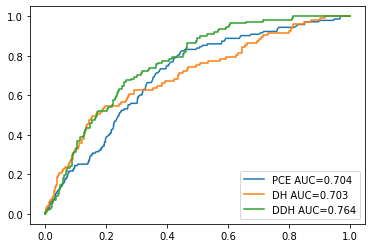

In [48]:
plt.plot(pce_fpr, pce_tpr,label='PCE AUC='+str(auc1))
plt.plot(dh_roc_df['fpr'], dh_roc_df['tpr'],label='DH AUC='+str(auc3))
plt.plot(ddh_fpr, ddh_tpr,label='DDH AUC='+str(auc2))
plt.legend(loc=4)

In [55]:
roc_df = pd.DataFrame({'fpr': ddh_fpr,
                       'tpr': ddh_tpr})
roc_df.to_csv('/Users/Excenity/Documents/HSIP/Research/Longitudinal PCE/GitHub/PCE_Dynamic-DeepHit/ddh_roc_df.csv', index = False)

In [174]:
dh_fpr, dh_tpr

NameError: name 'dh_fpr' is not defined

## Compare Population Groups

1. Get predicted probabilities of risk
2. Get the appropriate labels
3. Get relevant demographics of participants 
4. Create AUCs for respective participants

In [89]:
### Dynamic DeepHit
# Time Of Interest
pred_time_i = 2
pred_time_ia = 5
eval_time_i = 3
eval_time_ia= 10

# get prediction risk
pred_df = prediction_df(risk_all, 1)
# get only the evaluation time of 10 years
pred_df = pred_df[(pred_df['eval_time'] == eval_time_i) & (pred_df['pred_time'] == pred_time_ia)]

# get true labels
time_horizon = pred_time_ia + eval_time_ia
true = (te_time <= time_horizon) * (te_label == 1).astype(int)
pred_df['true_label'] = true

# get actual demographics data
demo_df = pd.DataFrame(te_data_raw[:,pred_time_i])
demo_df.columns = ['x', 'sbp', 'dbp', 'hdl', 'chol', 'age', 'cig', 'dm03', 'htnmed', 'race', 'gender']

demo_df = demo_df.reset_index()
pred_df = pred_df.reset_index()
final = pd.concat([demo_df, pred_df], axis = 1)

#final = final.drop(columns = ['level_0', 'index', 'x'])

In [117]:
### PCEs
pce_pred_df = pce_pred_df.reset_index()
pce_pred_df = pce_pred_df[['risk']]
pce_df = pce_df.reset_index()
pce_df['true_label'] = true
final_pce = pd.concat([pce_pred_df, pce_df], axis = 1)

In [16]:
from plotnine import ggplot, aes, geom_point, theme_bw, xlab, ylab, geom_smooth, xlim, ylim, geom_col, geom_text, position_dodge

### Race Comparisons
1. Black
2. White and Other Races

In [92]:
# convert race categories
final.loc[final['race'] == 1, 'race'] = 'white'
final.loc[final['race'] == 2, 'race'] = 'asian'
final.loc[final['race'] == 3, 'race'] = 'black'
final.loc[final['race'] == 4, 'race'] = 'hispanic'

In [134]:
# black comparison
### Dynamic DeepHit
final_t = final.loc[final['race'] == 'black', :]
print('DDH AUC: ', round(roc_auc_score(final_t['true_label'].tolist(), final_t['value'].tolist()),3))
### PCE
final_pce_t = final_pce.loc[final_pce['race'] == 'black', :]
print('PCE AUC: ', round(roc_auc_score(final_pce_t['true_label'].tolist(), final_pce_t['risk'].tolist()),3))

DDH AUC:  0.747
PCE AUC:  0.734


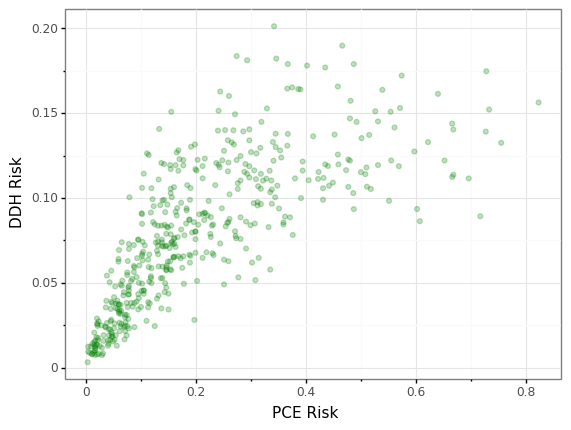

<ggplot: (8777728974761)>

In [135]:
final_tt = final_t.iloc[:,[0,16]]
final_pce_tt = final_pce_t.loc[: ,['index', 'risk']]
comp_df = pd.merge(final_tt, final_pce_tt, how = 'left', on = 'index')

ggplot(comp_df) + aes(x = 'risk', y = 'value') + geom_point(alpha = .25, color = 'green') + theme_bw() + xlab('PCE Risk') + ylab('DDH Risk') #+ xlim(0,1) + ylim(0,1) #+ geom_smooth(method='lm') 

In [98]:
print(final_t.value.mean())
print(final_pce_t.risk.mean())

0.07997440678134028
0.20956092436974785


In [113]:
# other comparison
final_t = final.loc[final['race'] != 'black', :]
print('DDH AUC: ', round(roc_auc_score(final_t['true_label'].tolist(), final_t['value'].tolist()),3))
### PCE
final_pce_t = final_pce.loc[final_pce['race'] != 'black', :]
final_pce_t = final_pce_t.dropna()
print('PCE AUC: ', round(roc_auc_score(final_pce_t['true_label'].tolist(), final_pce_t['risk'].tolist()),3))

DDH AUC:  0.752
PCE AUC:  0.736


/opt/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 312 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


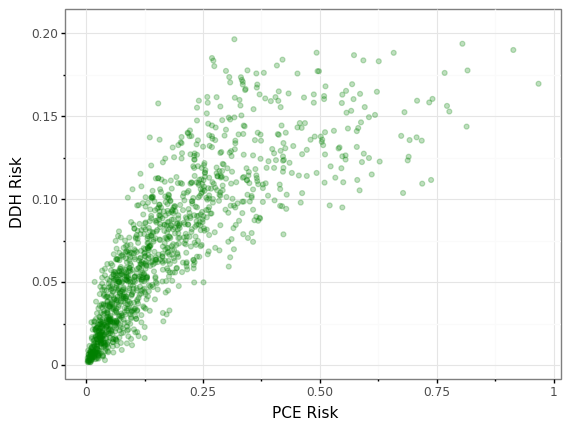

<ggplot: (8777728740457)>

In [130]:
final_tt = final_t.iloc[:,[0,16]]
final_pce_tt = final_pce_t.loc[: ,['index', 'risk']]
comp_df = pd.merge(final_tt, final_pce_tt, how = 'left', on = 'index')

ggplot(comp_df) + aes(x = 'risk', y = 'value') + geom_point(alpha = .25, color = 'green') + theme_bw() + xlab('PCE Risk') + ylab('DDH Risk') #+ geom_smooth(method='lm', color = 'green')

In [115]:
print(final_t.value.mean())
print(final_pce_t.risk.mean())

0.07912693965563408
0.17889426957223573


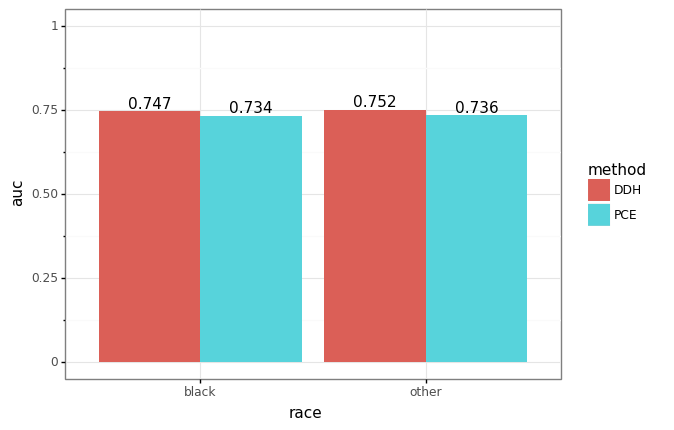

<ggplot: (8782309764125)>

In [32]:
race_auc = pd.DataFrame({'race':['black', 'black', 'other', 'other'],
                         'method': ['DDH', 'PCE', 'DDH', 'PCE'],
                         'auc': [0.747, 0.734, 0.752, 0.736]})

ggplot(race_auc) + aes(x = 'race', y = 'auc', fill = 'method') + geom_col(position = 'dodge') + ylim (0,1) + geom_text(aes(label='auc'), va = 'bottom', position=position_dodge(width=0.9)) + theme_bw()

### Gender Comparisons
1. Female
2. Male

In [137]:
# female comparison
### Dynamic DeepHit
final_t = final.loc[final['gender'] == 0, :]
print('DDH AUC: ', round(roc_auc_score(final_t['true_label'].tolist(), final_t['value'].tolist()),3))
### PCE
final_pce_t = final_pce.loc[final_pce['gender'] == 'F', :]
final_pce_t = final_pce_t.dropna()
print('PCE AUC: ', round(roc_auc_score(final_pce_t['true_label'].tolist(), final_pce_t['risk'].tolist()),3))

DDH AUC:  0.763
PCE AUC:  0.764


/opt/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 307 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


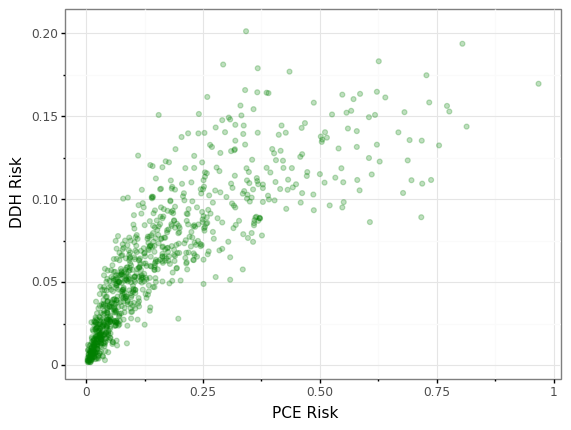

<ggplot: (8777729396385)>

In [138]:
final_tt = final_t.iloc[:,[0,16]]
final_pce_tt = final_pce_t.loc[: ,['index', 'risk']]
comp_df = pd.merge(final_tt, final_pce_tt, how = 'left', on = 'index')

ggplot(comp_df) + aes(x = 'risk', y = 'value') + geom_point(alpha = .25, color = 'green') + theme_bw() + xlab('PCE Risk') + ylab('DDH Risk') #+ xlim(0,1) + ylim(0,1) #+ geom_smooth(method='lm') 

In [139]:
# male comparison
final_t = final.loc[final['gender'] != 0, :]
print('DDH AUC: ', round(roc_auc_score(final_t['true_label'].tolist(), final_t['value'].tolist()),3))
### PCE
final_pce_t = final_pce.loc[final_pce['gender'] == 'M', :]
final_pce_t = final_pce_t.dropna()
print('PCE AUC: ', round(roc_auc_score(final_pce_t['true_label'].tolist(), final_pce_t['risk'].tolist()),3))

DDH AUC:  0.735
PCE AUC:  0.693


/opt/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 25 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


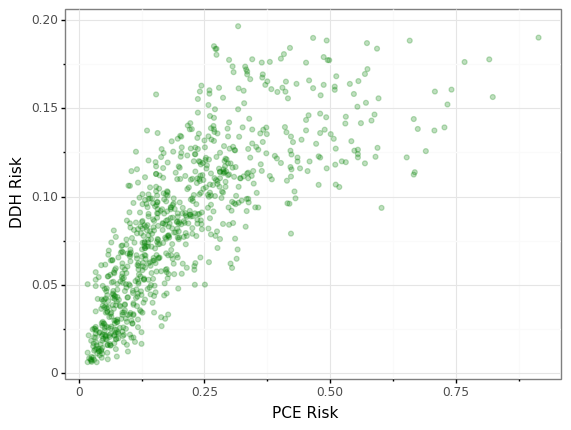

<ggplot: (8777729193873)>

In [140]:
final_tt = final_t.iloc[:,[0,16]]
final_pce_tt = final_pce_t.loc[: ,['index', 'risk']]
comp_df = pd.merge(final_tt, final_pce_tt, how = 'left', on = 'index')

ggplot(comp_df) + aes(x = 'risk', y = 'value') + geom_point(alpha = .25, color = 'green') + theme_bw() + xlab('PCE Risk') + ylab('DDH Risk') #+ xlim(0,1) + ylim(0,1) #+ geom_smooth(method='lm') 

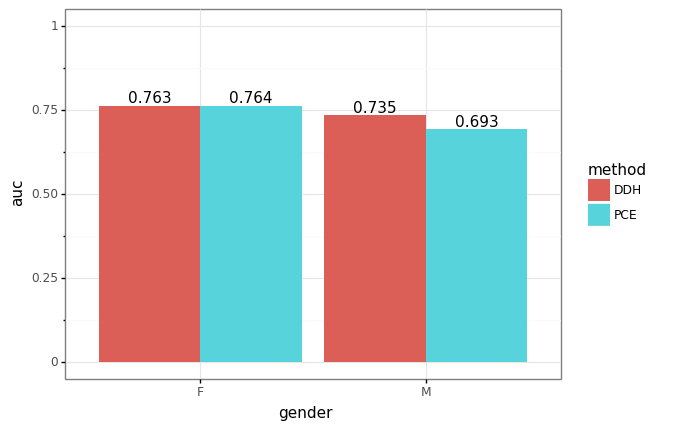

<ggplot: (8782309766957)>

In [33]:
gender_auc = pd.DataFrame({'gender':['F', 'F', 'M', 'M'],
                         'method': ['DDH', 'PCE', 'DDH', 'PCE'],
                         'auc': [0.763, 0.764, 0.735, 0.693]})

ggplot(gender_auc) + aes(x = 'gender', y = 'auc', fill = 'method') + geom_col(position = 'dodge') + ylim (0,1) + geom_text(aes(label='auc'), va = 'bottom', position=position_dodge(width=0.9)) + theme_bw()

### Age Comparisons
1. 45-65
2. 65-85

In [141]:
# Create Age Groups
final['age_group'] = '44-64'
final.loc[final['age'] > 65, 'age_group'] = '65-85'
final_pce['age_group'] = '44-64'
final_pce.loc[final_pce['age'] > 65, 'age_group'] = '65-85'

In [142]:
# young comparison
### Dynamic DeepHit
final_t = final.loc[final['age_group'] == '44-64', :]
print('DDH AUC: ', round(roc_auc_score(final_t['true_label'].tolist(), final_t['value'].tolist()),3))
### PCE
final_pce_t = final_pce.loc[final_pce['age_group'] == '44-64', :]
final_pce_t = final_pce_t.dropna()
print('PCE AUC: ', round(roc_auc_score(final_pce_t['true_label'].tolist(), final_pce_t['risk'].tolist()),3))

DDH AUC:  0.752
PCE AUC:  0.624


/opt/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 305 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


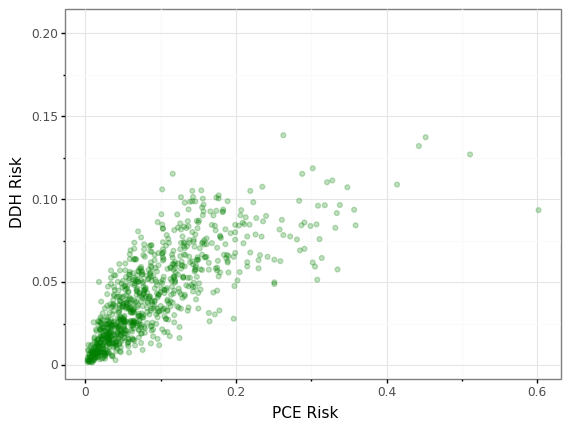

<ggplot: (8777729280601)>

In [143]:
final_tt = final_t.iloc[:,[0,16]]
final_pce_tt = final_pce_t.loc[: ,['index', 'risk']]
comp_df = pd.merge(final_tt, final_pce_tt, how = 'left', on = 'index')

ggplot(comp_df) + aes(x = 'risk', y = 'value') + geom_point(alpha = .25, color = 'green') + theme_bw() + xlab('PCE Risk') + ylab('DDH Risk') #+ xlim(0,1) + ylim(0,1) #+ geom_smooth(method='lm') 

In [144]:
# old comparison
final_t = final.loc[final['age_group'] == '65-85', :]
print('DDH AUC: ', round(roc_auc_score(final_t['true_label'].tolist(), final_t['value'].tolist()),3))
### PCE
final_pce_t = final_pce.loc[final_pce['age_group'] == '65-85', :]
final_pce_t = final_pce_t.dropna()
print('PCE AUC: ', round(roc_auc_score(final_pce_t['true_label'].tolist(), final_pce_t['risk'].tolist()),3))

DDH AUC:  0.71
PCE AUC:  0.654


/opt/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 27 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


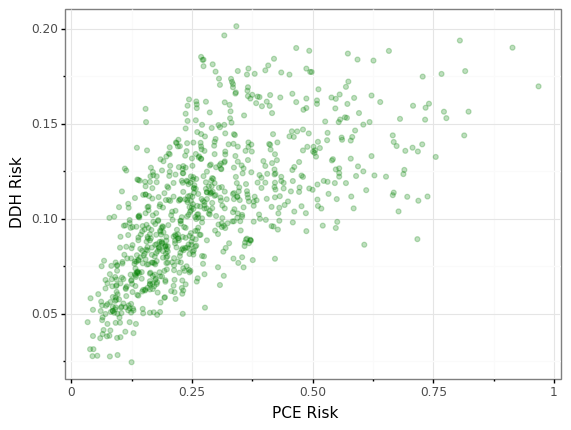

<ggplot: (8777729635461)>

In [145]:
final_tt = final_t.iloc[:,[0,16]]
final_pce_tt = final_pce_t.loc[: ,['index', 'risk']]
comp_df = pd.merge(final_tt, final_pce_tt, how = 'left', on = 'index')

ggplot(comp_df) + aes(x = 'risk', y = 'value') + geom_point(alpha = .25, color = 'green') + theme_bw() + xlab('PCE Risk') + ylab('DDH Risk') #+ xlim(0,1) + ylim(0,1) #+ geom_smooth(method='lm') 

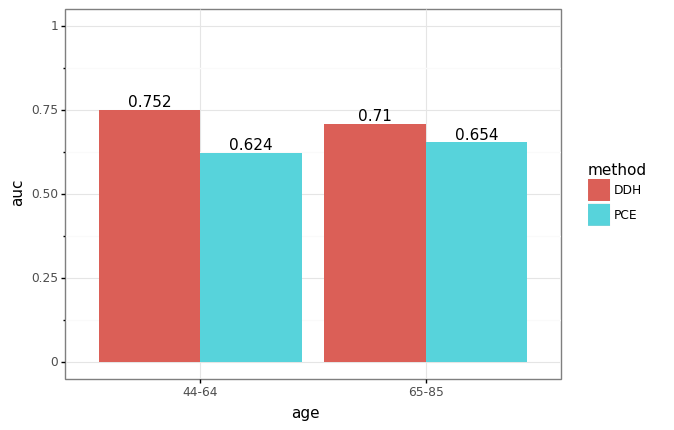

<ggplot: (8782309031457)>

In [31]:
age_auc = pd.DataFrame({'age':['44-64', '44-64', '65-85', '65-85'],
                         'method': ['DDH', 'PCE', 'DDH', 'PCE'],
                         'auc': [0.752, 0.624, 0.710, 0.654]})

ggplot(age_auc) + aes(x = 'age', y = 'auc', fill = 'method') + geom_col(position = 'dodge') + ylim (0,1) + geom_text(aes(label='auc'), va = 'bottom', position=position_dodge(width=0.9)) + theme_bw()

### Risk Group Comparisons
1. Above 7.5% Group

In [146]:
# Label Risk Group
final_pce['primary_risk'] = 0
final_pce.loc[final_pce['risk']>=0.075, 'primary_risk'] = 1
final['primary_risk'] = 0
final.loc[final_pce['primary_risk'] == 1, 'primary_risk'] = 1

In [147]:
# high comparison
### Dynamic DeepHit
final_t = final.loc[final['primary_risk'] == 1, :]
print('DDH AUC: ', round(roc_auc_score(final_t['true_label'].tolist(), final_t['value'].tolist()),3))
### PCE
final_pce_t = final_pce.loc[final_pce['primary_risk'] == 1, :]
final_pce_t = final_pce_t.dropna()
print('PCE AUC: ', round(roc_auc_score(final_pce_t['true_label'].tolist(), final_pce_t['risk'].tolist()),3))

DDH AUC:  0.725
PCE AUC:  0.697


/opt/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 36 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


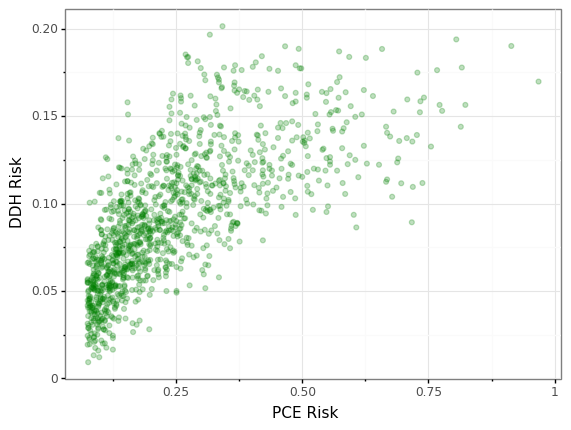

<ggplot: (8777729423109)>

In [148]:
final_tt = final_t.iloc[:,[0,16]]
final_pce_tt = final_pce_t.loc[: ,['index', 'risk']]
comp_df = pd.merge(final_tt, final_pce_tt, how = 'left', on = 'index')

ggplot(comp_df) + aes(x = 'risk', y = 'value') + geom_point(alpha = .25, color = 'green') + theme_bw() + xlab('PCE Risk') + ylab('DDH Risk') #+ xlim(0,1) + ylim(0,1) #+ geom_smooth(method='lm') 

In [149]:
# low comparison
final_t = final.loc[final['primary_risk'] == 0, :]
print('DDH AUC: ', round(roc_auc_score(final_t['true_label'].tolist(), final_t['value'].tolist()),3))
### PCE
final_pce_t = final_pce.loc[final_pce['primary_risk'] == 0, :]
final_pce_t = final_pce_t.dropna()
print('PCE AUC: ', round(roc_auc_score(final_pce_t['true_label'].tolist(), final_pce_t['risk'].tolist()),3))

DDH AUC:  0.783
PCE AUC:  0.558


/opt/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 296 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


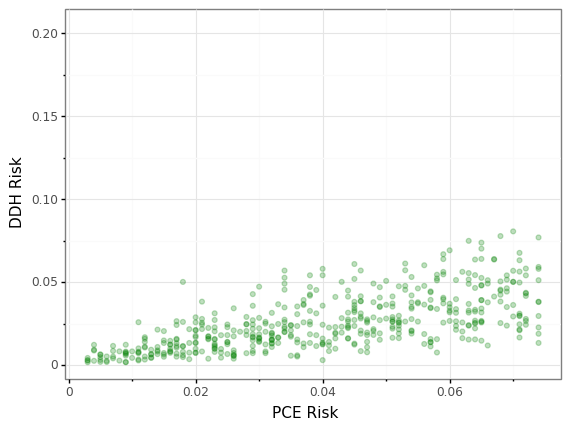

<ggplot: (8777729317789)>

In [150]:
final_tt = final_t.iloc[:,[0,16]]
final_pce_tt = final_pce_t.loc[: ,['index', 'risk']]
comp_df = pd.merge(final_tt, final_pce_tt, how = 'left', on = 'index')

ggplot(comp_df) + aes(x = 'risk', y = 'value') + geom_point(alpha = .25, color = 'green') + theme_bw() + xlab('PCE Risk') + ylab('DDH Risk') #+ xlim(0,1) + ylim(0,1) #+ geom_smooth(method='lm') 

### Visualization

In [32]:
from visualization import get_data, viz_dataset, dup_list, create_outcome_df, create_pce_df, create_outcome_final_df, viz_plot

In [13]:
patient_id = 273
death_pred , ascvd_pred, pce_data = get_data(patient_id, risk_all, te_data_raw)
pce_data = create_pce_df(pce_data)
outcome_df = create_outcome_final_df(ascvd_pred, death_pred, pred_time, eval_time)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/Users/Excenity/Documents/HSIP/Research/Longitudinal PCE/GitHub/Dynamic-DeepHit copy/visualization.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pce_data['med_change'] = pce_data['htnmed'] - pce_data.shift(+1)['htnmed']


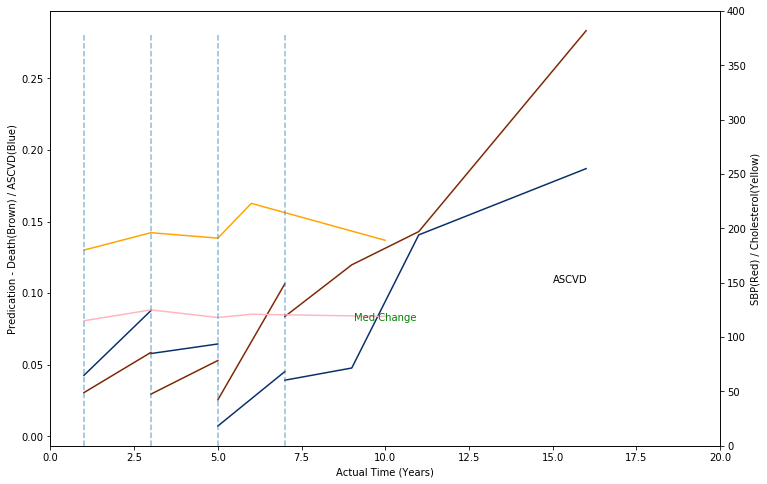

In [14]:
viz_plot(outcome_df, pce_data, te_label[patient_id][0], te_time[patient_id][0], pred_time)